In [58]:
import sys
sys.path.append('./src')

import os
import time

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dataset import CausalMNIST
from visualize import visualize_n_digits, boxplot_ead
from utils import set_seed
from train import training, performances_all, performances_val
from scipy.stats import ttest_ind, ttest_1samp

Causal MNIST dataset already exists
Causal MNIST dataset environments already exists


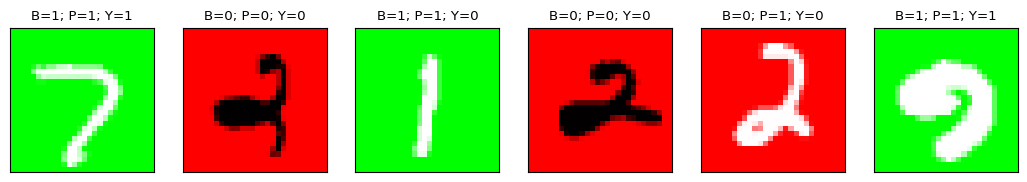

In [59]:
# load the dataset
subsampling = "random"
train = CausalMNIST(root='./data', 
                    env='train', 
                    force_generation=False, 
                    force_split=False, 
                    subsampling=subsampling)
# visualize examples
visualize_n_digits(train, 6, save=True)

In [ ]:
# example training
model = training(force_generation=False, 
                  subsampling='biased',
                  verbose=True,
                  train_ratio = 0.02)

Training Set
E[D|B=0] = 3.564389705657959
E[D|B=1] = 5.2205071449279785
E[Y|B=0] = 0.43449047207832336
E[Y|B=1] = 0.7364939451217651
EAD = 0.3020034730434418


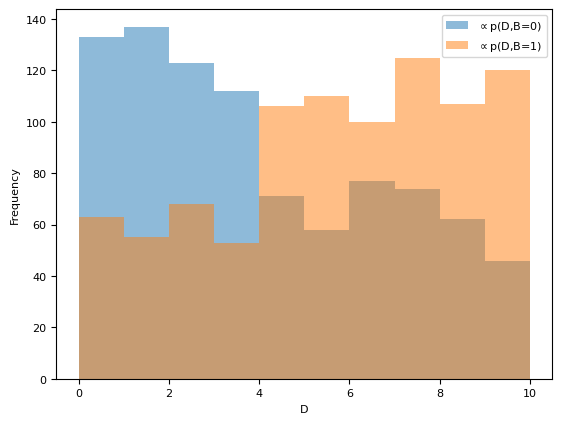

In [60]:
# Exploratory data analysis
labels = torch.tensor([label for _, label in train.data_label_tuples])
B, P, D, Y = labels[:, 0], labels[:, 1], labels[:, 2], labels[:, 3]

print("Training Set")
print(f'E[D|B=0] = {D[B==0].float().mean()}')
print(f'E[D|B=1] = {D[B==1].float().mean()}')
print(f'E[Y|B=0] = {Y[B==0].float().mean()}')
print(f'E[Y|B=1] = {Y[B==1].float().mean()}')
print(f'EAD = {Y[B==1].float().mean() - Y[B==0].float().mean()}')

# plot the distribution of D given B (no subplot)
fig, ax = plt.subplots()
ax.hist(D[B==0], bins=range(11), alpha=0.5, label=r'$\propto$p(D,B=0)')
ax.hist(D[B==1], bins=range(11), alpha=0.5, label=r'$\propto$p(D,B=1)')
ax.set_xlabel('D')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [ ]:
# Run Experiment

# settings
n_seeds = 100
subsampling = "random"
train_ratios = [0.2, 0.03] #list(0.005 + 0.005 * i for i in range(20))
verbose = False

results = pd.DataFrame(columns=['train_ratio', 'seed', 'loss_val', 'acc_val', 'bacc_val', 'TEB_val', 'acc', 'bacc', 'TEB', 'TEB_bin', 'ead'])
i = 0
start_time = time.time()
for train_ratio in train_ratios:
  for seed in range(0, n_seeds):
    print(f"Experiment {i+1}/{n_seeds*len(train_ratios)} - train_ratio: {train_ratio} - seed: {seed}")
    set_seed(seed)
    model = training(force_generation=True, 
                  subsampling=subsampling,
                  verbose=verbose,
                  train_ratio = train_ratio)
    val_loader = torch.utils.data.DataLoader(
      CausalMNIST(root='./data', 
                  env='val',
                  transform=model.transformations,
                  subsampling=subsampling,
                  verbose=verbose),
      batch_size=1000, shuffle=False)
    all_loader = torch.utils.data.DataLoader(
      CausalMNIST(root='./data', 
                  env='all',
                  transform=model.transformations,
                  subsampling=subsampling,
                  verbose=verbose),
      batch_size=1000, shuffle=False)
    

    loss_val, acc_val, bacc_val, TEB_val = performances_val(model, val_loader)
    acc, bacc, TEB, TEB_bin, ead = performances_all(model, all_loader)
    results.loc[i] = {'train_ratio': train_ratio, 'seed': seed, 'loss_val': loss_val, 'acc_val': acc_val, 'bacc_val': bacc_val, 'TEB_val': TEB_val, 'acc': acc, 'bacc': bacc, 'TEB': TEB, 'TEB_bin': TEB_bin, 'ead': ead}
    i+=1
    
if not os.path.exists(f'results/CausalMNIST/{subsampling}'):
    os.makedirs(f'results/CausalMNIST/{subsampling}')
results.to_csv(f'results/CausalMNIST/{subsampling}/results.csv', index=False)
results

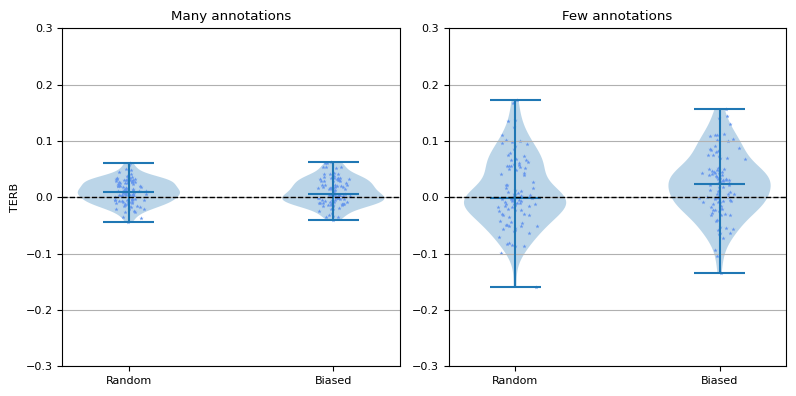

In [61]:
results_random = pd.read_csv(f'results/CausalMNIST/random/results.csv')
results_biased = pd.read_csv(f'results/CausalMNIST/biased/results.csv')

results_biased["TERB"] = results_biased["TEB"] / 0.3
results_random["TERB"] = results_random["TEB"] / 0.3
random_easy = results_random[results_random["train_ratio"] == 0.2]
random = results_random[results_random["train_ratio"] == 0.03]
biased_easy = results_biased[results_biased["train_ratio"] == 0.2]
biased = results_biased[results_biased["train_ratio"] == 0.03]


k = 0.3
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# plot violin plot
axs[0].violinplot([random_easy["TERB"], biased_easy["TERB"]],
                  showmeans=False,
                  showmedians=True)
axs[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axs[0].set_ylim(-k, k)
axs[0].set_title(r"Many annotations")

for i, y in zip([1,2], [random_easy["TERB"], biased_easy["TERB"]]):
    x = np.random.normal(i, 0.04, size=len(y))
    axs[0].scatter(x, y, alpha=1, color='cornflowerblue', s=10, marker='*', linewidths=0)

# plot box plot
axs[1].violinplot([random["TERB"], biased["TERB"]],
                  showmeans=False,
                  showmedians=True)
axs[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axs[1].set_title(r"Few annotations")
axs[1].set_ylim(-k, k)

for i, y in zip([1,2], [random["TERB"], biased["TERB"]]):
    x = np.random.normal(i, 0.04, size=len(y))
    axs[1].scatter(x, y, alpha=1, color='cornflowerblue', s=10, marker='*', linewidths=0)

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(2)],
                  labels=['Random', 'Biased'])
axs[0].set_ylabel('TERB')

# save plot as pdf
plt.tight_layout()
plt.savefig(f"results/sampling_bias_cm.pdf")
plt.show()

In [62]:
# t test random_easy has mean 0
t, pvalue = ttest_1samp(random_easy["TEB"], 0, alternative='two-sided')
print(f"Random Easy: t={t:.4f}, p={pvalue}, mu: {random_easy['TEB'].mean()*100:.2f}%")
t, pvalue = ttest_1samp(random["TEB"], 0, alternative='two-sided')
print(f"Random: t={t:.4f}, p={pvalue}, mu: {random['TEB'].mean()*100:.2f}%")
t, pvalue = ttest_1samp(biased_easy["TEB"], 0, alternative='two-sided')
print(f"Biased Easy: t={t:.4f}, p={pvalue}, mu: {biased_easy['TEB'].mean()*100:.2f}%")
t, pvalue = ttest_1samp(biased["TEB"], 0, alternative='two-sided')
print(f"Biased: t={t:.4f}, p={pvalue}, mu: {biased['TEB'].mean()*100:.2f}%")

Random Easy: t=4.4215, p=2.5159991577645955e-05, mu: 0.28%
Random: t=1.6074, p=0.11115764339277386, mu: 0.30%
Biased Easy: t=4.0301, p=0.00010956972936234554, mu: 0.28%
Biased: t=3.9116, p=0.00016820615379279193, mu: 0.66%


lowest Balanced Accuracy: 0.9605038930634616


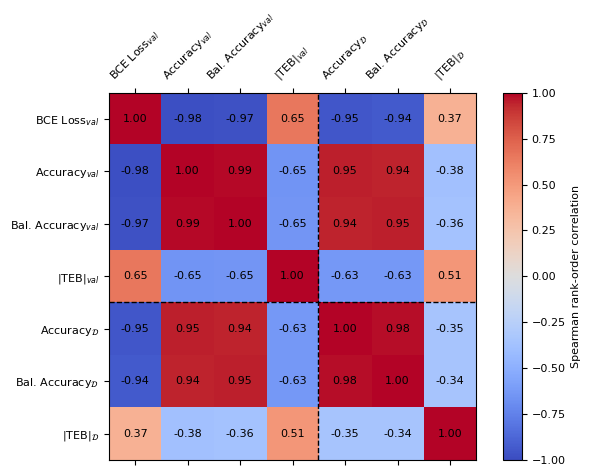

In [63]:
subsampling = "random"
results = pd.read_csv(f'results/CausalMNIST/{subsampling}/results.csv')

# n = 100
# results = results.sort_values("bacc", ascending=False)[:n]
print(f"lowest Balanced Accuracy: {results['bacc'].iloc[-1]}")

results = results.iloc[:, 2:]
results["TEB_val"] = abs(results["TEB_val"])
results["TEB"] = abs(results["TEB"])
results["TEB_bin"] = abs(results["TEB_bin"])
results = results.drop(columns=["ead", "TEB_bin"])

corr_matrix = results.corr(method='spearman')
corr_matrix.columns = ['BCE Loss$_{val}$', 'Accuracy$_{val}$', 'Bal. Accuracy$_{val}$', '|TEB|$_{val}$', 'Accuracy$_\mathcal{D}$', 'Bal. Accuracy$_\mathcal{D}$', '|TEB|$_\mathcal{D}$']


fig, ax = plt.subplots()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.axvline(x=3.49, color='black', linewidth=1, linestyle='--')
plt.axhline(y=3.49, color='black', linewidth=1, linestyle='--')
colorbar = fig.colorbar(cax)
colorbar.set_label('Spearman rank-order correlation')
# save plot as pdf
plt.tight_layout()
plt.savefig(f"results/evaluation_{subsampling}_cm.pdf")
plt.show()

In [64]:
results_random = pd.read_csv(f'results/CausalMNIST/random/results.csv')
results_biases = pd.read_csv(f'results/CausalMNIST/biased/results.csv')
# merge
results = pd.concat([results_random, results_biases])


t_statistic, p_value = ttest_ind(abs(results['TEB']), abs(results['TEB_bin']), alternative='two-sided')
print(f"|TEB|=|TEB_bin|: p-value={p_value}, t-statistic={t_statistic}")
print("TEB_bin/TEB:", results_random['TEB_bin'].mean()/results_random['TEB'].mean())

|TEB|=|TEB_bin|: p-value=0.23508846185860874, t-statistic=1.1882499542482665
TEB_bin/TEB: 1.7259311727539157


In [65]:
results_random['TEB_bin'].mean()/results_random['TEB'].mean()

1.7259311727539157

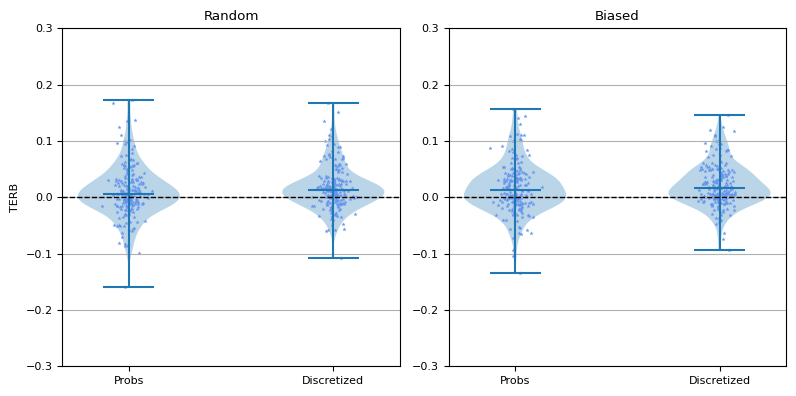

In [66]:
results_random = pd.read_csv(f'results/CausalMNIST/random/results.csv')
results_biased = pd.read_csv(f'results/CausalMNIST/biased/results.csv')

results_biased["TERB"] = results_biased["TEB"] / 0.3
results_random["TERB"] = results_random["TEB"] / 0.3
results_biased["TERB_bin"] = results_biased["TEB_bin"] / 0.3
results_random["TERB_bin"] = results_random["TEB_bin"] / 0.3
random_easy = results_random[results_random["train_ratio"] == 0.2]
random = results_random[results_random["train_ratio"] == 0.03]
biased_easy = results_biased[results_biased["train_ratio"] == 0.2]
biased = results_biased[results_biased["train_ratio"] == 0.03]


k = 0.3
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# plot violin plot
axs[0].violinplot([results_random["TERB"], results_random["TERB_bin"]],
                  showmeans=False,
                  showmedians=True)
axs[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axs[0].set_ylim(-k, k)
axs[0].set_title(r"Random")

for i, y in zip([1,2], [results_random["TERB"], results_random["TERB_bin"]]):
    x = np.random.normal(i, 0.04, size=len(y))
    axs[0].scatter(x, y, alpha=1, color='cornflowerblue', s=10, marker='*', linewidths=0)

# plot box plot
axs[1].violinplot([results_biased["TERB"], results_biased["TERB_bin"]],
                  showmeans=False,
                  showmedians=True)
axs[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axs[1].set_title(r"Biased")
axs[1].set_ylim(-k, k)

for i, y in zip([1,2], [results_biased["TERB"], results_biased["TERB_bin"]]):
    x = np.random.normal(i, 0.04, size=len(y))
    axs[1].scatter(x, y, alpha=1, color='cornflowerblue', s=10, marker='*', linewidths=0)

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(2)],
                  labels=['Probs', 'Discretized'])
axs[0].set_ylabel('TERB')

# save plot as pdf
plt.tight_layout()
plt.savefig(f"results/discretization_bias_cm.pdf")
plt.show()